In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import itertools
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
from shapely.wkt import loads
# import contextily as ctx
%matplotlib inline

del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()
# plt.rcParams[\"font.family\"] = \"Times New Roman\"
font = {'family' : 'Times New Roman', 'weight' : 'normal'}
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', **font)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# matplotlib.rc('text', usetex = True)     ### use latex symbols

In [52]:
### add geometry

nodes_df0 = pd.read_csv('projects/berkeley/network_inputs/osm_nodes.csv')
links_df0 = pd.read_csv('projects/berkeley/network_inputs/modified_network_edges.csv')

### counterflow
cf_files = ['projects/berkeley/network_inputs/marin.csv', 
        'projects/berkeley/network_inputs/spruce.csv',
        'projects/berkeley/network_inputs/cedar.csv',
        'projects/berkeley/network_inputs/rose.csv',
        'projects/berkeley/network_inputs/shasta.csv',
        ]
### read counterflow links
cf_links = []
for cf_file in cf_files:
    cf_link_df = pd.read_csv(cf_file)
    cf_links.append(cf_link_df)
cf_links_df = pd.concat(cf_links)
### along counterflow direction
cf_links_id = cf_links_df.loc[cf_links_df['along']==1, 'edge_id_igraph']
links_df0['lanes'] = np.where(links_df0['edge_id_igraph'].isin(cf_links_id), links_df0['lanes']*2, links_df0['lanes'])
### opposite counterflow direction
opcf_links_id = cf_links_df.loc[cf_links_df['along']==0, 'edge_id_igraph']
links_df0['lanes'] = np.where(links_df0['edge_id_igraph'].isin(opcf_links_id), 0, links_df0['lanes'])
links_df0['maxmph'] = np.where(links_df0['edge_id_igraph'].isin(opcf_links_id), 0.000001, links_df0['maxmph'])

link_df = links_df0.copy()

# print(link_df[link_df['edge_id_igraph']==16358])
for t in range(0,10801,900):
    node_stats_file = 'node_stats_rs5_f1_dtfst_tow0.1_hhvsurvey_r0.15_pt0_cf0_t{}.csv'.format(t)
    node_stats = pd.read_csv('projects/berkeley/simulation_outputs/node_stats_export/' + node_stats_file)
    node_stats = pd.merge(node_stats, nodes_df0, how='left', left_on='node_id', right_on='node_id_igraph')
    node_stats.to_csv('projects/berkeley/visualization_outputs/link_stats_geom/'+node_stats_file, index=False)
    
    link_stats_file = 'link_stats_rs5_f1_dtfst_tow0.1_hhvsurvey_r0.15_pt0_cf0_t{}.csv'.format(t)
    link_stats = pd.read_csv('projects/berkeley/simulation_outputs/link_stats_export/' + link_stats_file)
    link_stats = pd.merge(link_stats, link_df[['edge_id_igraph', 'geometry', 'length', 'lanes', 'fft']], how='left', left_on='link_id', right_on='edge_id_igraph')
    link_stats['density_len'] = np.where(link_stats['length']<15, 15, link_stats['length'])
    link_stats['q_density'] = link_stats['q']/(link_stats['density_len']*link_stats['lanes'])
    link_stats['r_density'] = link_stats['r']/(link_stats['density_len']*link_stats['lanes'])
    link_stats['qr_density'] = link_stats['q_density'] + link_stats['r_density']
    link_stats['t_delay'] = link_stats['t']/link_stats['fft']
#     link_stats_gdf = gpd.GeoDataFrame(link_stats, crs='EPSG:4326', geometry=link_stats['geometry'].apply(loads))
#     ax = link_stats_gdf.cx[-122.271870:-122.263610, 37.868026:37.876706].to_crs("EPSG:3857").plot(figsize=(15, 15)) 
#     ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
#     ax.set_axis_off()
#     break
#     print(link_stats[link_stats['edge_id_igraph']==16358])
    link_stats.to_csv('projects/berkeley/visualization_outputs/link_stats_geom/'+link_stats_file, index=False)

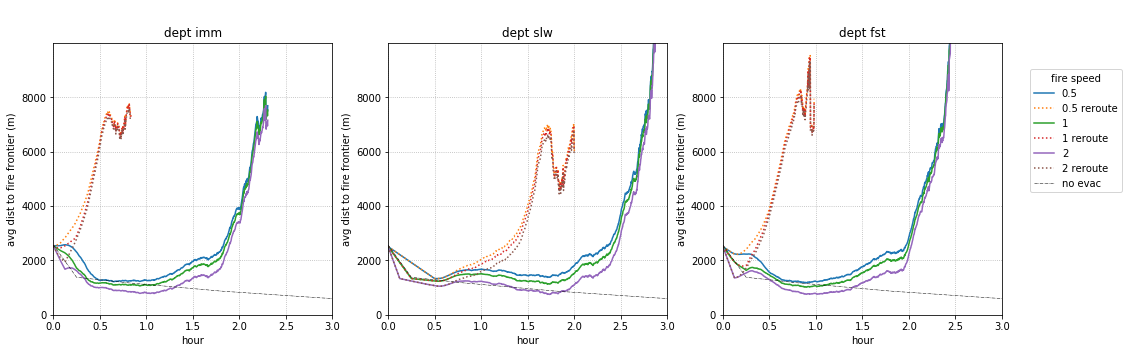

In [2]:
random_seed = 0
reroute = 0 ### 0, 1
# departure_time = 'imm' ### slw, imm, fst
tow_pct = 0 ### 0, 0.05, 0.1

fig, ax = plt.subplots(1, 3, figsize=(17,5))
fig.suptitle(' ')
ax_id = -1
for departure_time in ['imm', 'slw', 'fst']:
    ax_id += 1
    ax[ax_id].set_title('dept ' + departure_time)
    ax[ax_id].set_xlabel('hour')
    ax[ax_id].set_ylabel('avg dist to fire frontier (m)')
    ax[ax_id].set_xlim([0, 2.5])
    ax[ax_id].set_ylim([0, 10000])
    ax[ax_id].set_xticks(np.arange(0, 3.5, 0.5))
    ax[ax_id].set_yticks(np.arange(0, 10000, 2000))
    ax[ax_id].grid(ls=':')
    for fire_speed in [0.5, 1, 2]:
        res = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r0_f{}_dt{}_tow{}.csv'.format(
            random_seed, fire_speed, departure_time, tow_pct))
        ax[ax_id].plot(res['t']/3600, res['avg_fdist'], label=fire_speed)
        
        try:
            res_r1 = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r1_f{}_dt{}_tow{}.csv'.format(random_seed, fire_speed, departure_time, tow_pct))
            ax[ax_id].plot(res_r1['t']/3600, res_r1['avg_fdist'], label='{} reroute'.format(fire_speed), ls=':')
        except FileNotFoundError:
            ax[ax_id].plot([0,0], [0,0], label='{} reroute'.format(fire_speed), ls=':')
    ref = pd.read_csv('projects/berkeley/demand_inputs/fdist_ref.csv')
    ax[ax_id].plot(ref['t']/3600, ref['avg_fdist'], label='no evac', ls='-.', c='black', lw=0.5)
        
plt.legend(loc=[1.1,0.45], title='fire speed')
plt.show()

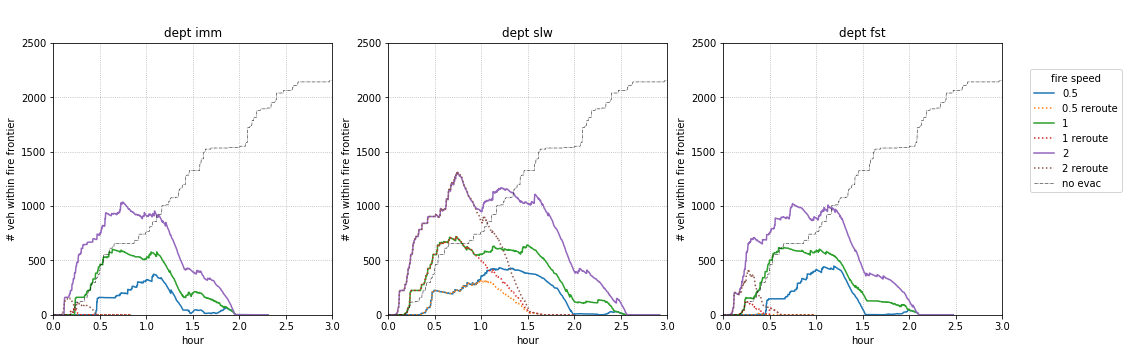

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(17,5))
fig.suptitle(' ')
ax_id = -1
for departure_time in ['imm', 'slw', 'fst']:
    ax_id += 1
    ax[ax_id].set_title('dept ' + departure_time)
    ax[ax_id].set_xlabel('hour')
    ax[ax_id].set_ylabel('# veh within fire frontier')
    ax[ax_id].set_xlim([0, 2.5])
    ax[ax_id].set_ylim([0, 2000])
    ax[ax_id].set_xticks(np.arange(0, 3.5, 0.5))
    ax[ax_id].set_yticks(np.arange(0, 3000, 500))
    ax[ax_id].grid(ls=':')
    for fire_speed in [0.5, 1, 2]:
        res = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r{}_f{}_dt{}_tow{}.csv'.format(
            random_seed, reroute, fire_speed, departure_time, tow_pct))
        ax[ax_id].plot(res['t']/3600, res['neg_fdist'], label=fire_speed)
        
        try:
            res_r1 = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r1_f{}_dt{}_tow{}.csv'.format(random_seed, fire_speed, departure_time, tow_pct))
            ax[ax_id].plot(res_r1['t']/3600, res_r1['neg_fdist'], label='{} reroute'.format(fire_speed), ls=':')
        except FileNotFoundError:
            ax[ax_id].plot([0,0], [0,0], label='{} reroute'.format(fire_speed), ls=':')
    
    ref = pd.read_csv('projects/berkeley/demand_inputs/fdist_ref.csv')
    ax[ax_id].plot(ref['t']/3600, ref['neg_fdist'], label='no evac', ls='-.', c='black', lw=0.5)

plt.legend(loc=[1.1,0.45], title='fire speed')
plt.show()

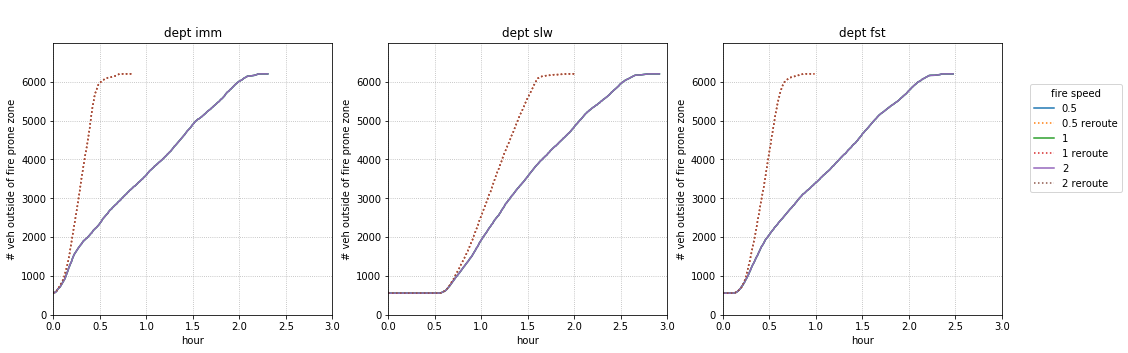

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(17,5))
fig.suptitle(' ')
ax_id = -1
for departure_time in ['imm', 'slw', 'fst']:
    ax_id += 1
    ax[ax_id].set_title('dept ' + departure_time)
    ax[ax_id].set_xlabel('hour')
    ax[ax_id].set_ylabel('# veh outside of fire prone zone')
    ax[ax_id].set_xlim([0, 2.5])
    ax[ax_id].set_ylim([0, 7000])
    ax[ax_id].set_xticks(np.arange(0, 3.5, 0.5))
    ax[ax_id].set_yticks(np.arange(0, 7000, 1000))
    ax[ax_id].grid(ls=':')
    for fire_speed in [0.5, 1, 2]:
        res = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r{}_f{}_dt{}_tow{}.csv'.format(
            random_seed, reroute, fire_speed, departure_time, tow_pct))
        ax[ax_id].plot(res['t']/3600, res['out_cnts']+res['arr'], label=fire_speed)
        
        try:
            res_r1 = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r1_f{}_dt{}_tow{}.csv'.format(random_seed, fire_speed, departure_time, tow_pct))
            ax[ax_id].plot(res_r1['t']/3600, res_r1['out_cnts']+res_r1['arr'], label='{} reroute'.format(fire_speed), ls=':')
        except FileNotFoundError:
            ax[ax_id].plot([0,0], [0,0], label='{} reroute'.format(fire_speed), ls=':')
            
plt.legend(loc=[1.1,0.45], title='fire speed')
plt.show()

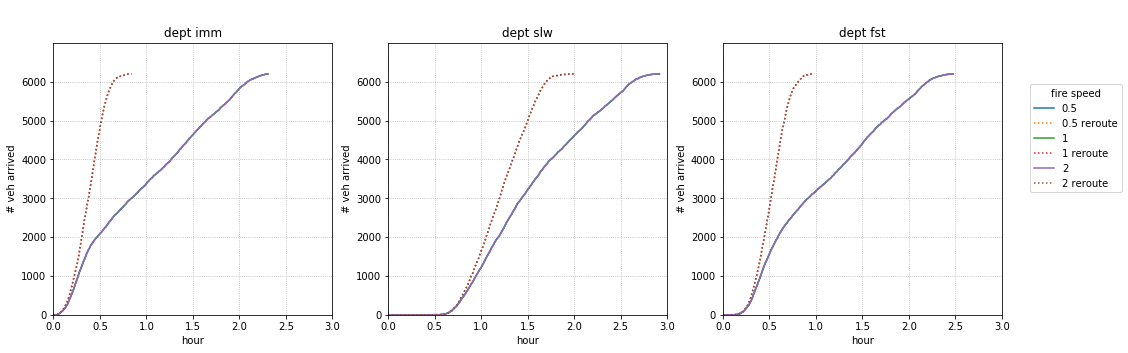

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(17,5))
fig.suptitle(' ')
ax_id = -1
for departure_time in ['imm', 'slw', 'fst']:
    ax_id += 1
    ax[ax_id].set_title('dept ' + departure_time)
    ax[ax_id].set_xlabel('hour')
    ax[ax_id].set_ylabel('# veh arrived')
    ax[ax_id].set_xlim([0, 2.5])
    ax[ax_id].set_ylim([0, 7000])
    ax[ax_id].set_xticks(np.arange(0, 3.5, 0.5))
    ax[ax_id].set_yticks(np.arange(0, 7000, 1000))
    ax[ax_id].grid(ls=':')
    for fire_speed in [0.5, 1, 2]:
        res = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r{}_f{}_dt{}_tow{}.csv'.format(
            random_seed, reroute, fire_speed, departure_time, tow_pct))
        ax[ax_id].plot(res['t']/3600, res['arr'], label=fire_speed)
        
        try:
            res_r1 = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r1_f{}_dt{}_tow{}.csv'.format(random_seed, fire_speed, departure_time, tow_pct))
            ax[ax_id].plot(res_r1['t']/3600, res_r1['arr'], label='{} reroute'.format(fire_speed), ls=':')
        except FileNotFoundError:
            ax[ax_id].plot([0,0], [0,0], label='{} reroute'.format(fire_speed), ls=':')
            
plt.legend(loc=[1.1,0.45], title='fire speed')
plt.show()

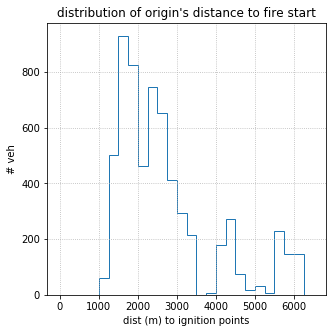

In [6]:
### phasing based on origin distance to fire ignition point
o_dist = pd.read_csv('projects/berkeley/simulation_outputs/od_dist_to_fire_start.csv')
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(o_dist['fire_point_dist'], bins=np.linspace(0, 6500, 27), 
               histtype=u'step')
ax.set_xlabel('dist (m) to ignition points')
ax.set_ylabel('# veh')
ax.set_title("distribution of origin's distance to fire start")
ax.set_xticks(np.arange(0, 6500, 1000))
ax.set_yticks(np.arange(0, 1000, 200))
ax.grid(ls=':')
plt.show()

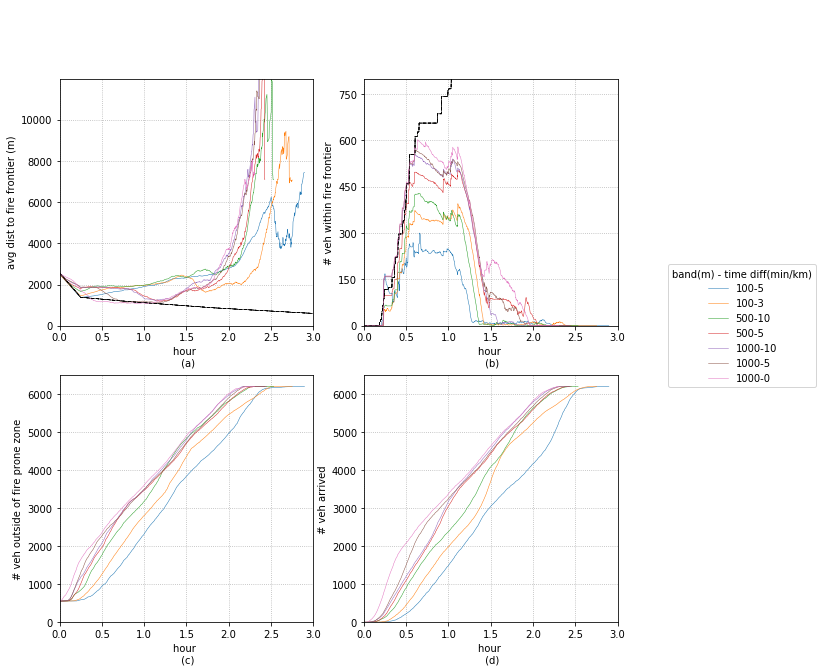

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(' ')

ref = pd.read_csv('projects/berkeley/demand_inputs/fdist_ref.csv')

for ps in ["100-5", "100-3", "500-10", "500-5", "1000-10", "1000-5", "1000-0"]:#["500-5", "500-10", "1000-0", "1000-5", "1000-10"]:
    res = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs0_r0_f1_dtimm_ps{}_tow0.csv'.format(ps))
    ax[0,0].plot(res['t']/3600, res['avg_fdist'], label=ps, lw=0.5)
    ax[0,0].plot(ref['t']/3600, ref['avg_fdist'], label='no evac', ls='-.', c='black', lw=0.5)
    ax[0,0].set_ylabel('avg dist to fire frontier (m)')
    ax[0,0].set_xlabel('hour \n (a)')
    ax[0,0].set_xlim([0, 2.5])
    ax[0,0].set_ylim([0, 12000])
    ax[0,0].set_xticks(np.arange(0, 3.5, 0.5))
    ax[0,0].set_yticks(np.arange(0, 12000, 2000))
    ax[0,0].grid(ls=':')
    
    ax[0,1].plot(res['t']/3600, res['neg_fdist'], label=ps, lw=0.5)
    ax[0,1].plot(ref['t']/3600, ref['neg_fdist'], label='no evac', ls='-.', c='black', lw=0.5)
    ax[0,1].set_ylabel('# veh within fire frontier')
    ax[0,1].set_xlabel('hour \n (b)')
    ax[0,1].set_xlim([0, 2.5])
    ax[0,1].set_ylim([0, 800])
    ax[0,1].set_xticks(np.arange(0, 3.5, 0.5))
    ax[0,1].set_yticks(np.arange(0, 800, 150))
    ax[0,1].grid(ls=':')
    
    ax[1,0].plot(res['t']/3600, res['out_cnts']+res['arr'], label=ps, lw=0.5)
    ax[1,0].set_ylabel('# veh outside of fire prone zone')
    ax[1,0].set_xlabel('hour \n (c)')
    ax[1,0].set_xlim([0, 2.5])
    ax[1,0].set_ylim([0, 6500])
    ax[1,0].set_xticks(np.arange(0, 3.5, 0.5))
    ax[1,0].set_yticks(np.arange(0, 6500, 1000))
    ax[1,0].grid(ls=':')
    
    ax[1,1].plot(res['t']/3600, res['arr'], label=ps, lw=0.5)
    ax[1,1].set_ylabel('# veh arrived')
    ax[1,1].set_xlabel('hour \n (d)')
    ax[1,1].set_xlim([0, 2.5])
    ax[1,1].set_ylim([0, 6500])
    ax[1,1].set_xticks(np.arange(0, 3.5, 0.5))
    ax[1,1].set_yticks(np.arange(0, 6500, 1000))
    ax[1,1].grid(ls=':')

plt.legend(loc=[1.2,0.95], title='band(m) - time diff(min/km)')
plt.show()

In [6]:
### Counterflow
### First visualize queue locations
link_df = pd.read_csv('projects/berkeley/network_inputs/osm_edges.csv')
for t in range(300, 3300, 300):
    link_stats = pd.read_csv('projects/berkeley/simulation_outputs/link_stats/link_stats_rs0_r1_f1_dtimm_ps1000-0_tow0_cf1_t{}.csv'.format(t))
    link_stats = pd.merge(link_stats, link_df[['edge_id_igraph', 'geometry', 'length', 'lanes']], how='left', left_on='link_id', right_on='edge_id_igraph')
    link_stats['density_len'] = np.where(link_stats['length']<18, 18, link_stats['length'])
    link_stats['q_density'] = link_stats['q']/(link_stats['density_len']*link_stats['lanes'])
    link_stats['r_density'] = link_stats['r']/(link_stats['density_len']*link_stats['lanes'])
    link_stats['qr_density'] = link_stats['q_density'] + link_stats['r_density']
#     link_stats_gdf = gpd.GeoDataFrame(link_stats, crs='EPSG:4326', geometry=link_stats['geometry'].apply(loads))
#     ax = link_stats_gdf.cx[-122.271870:-122.263610, 37.868026:37.876706].to_crs("EPSG:3857").plot(figsize=(15, 15)) 
#     ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
#     ax.set_axis_off()
#     break
    link_stats.to_csv('projects/berkeley/visualization_outputs/link_stats_geom/link_stats_rs0_r1_f1_dtimm_ps1000-0_tow0_cf1_t{}.csv'.format(t), index=False)

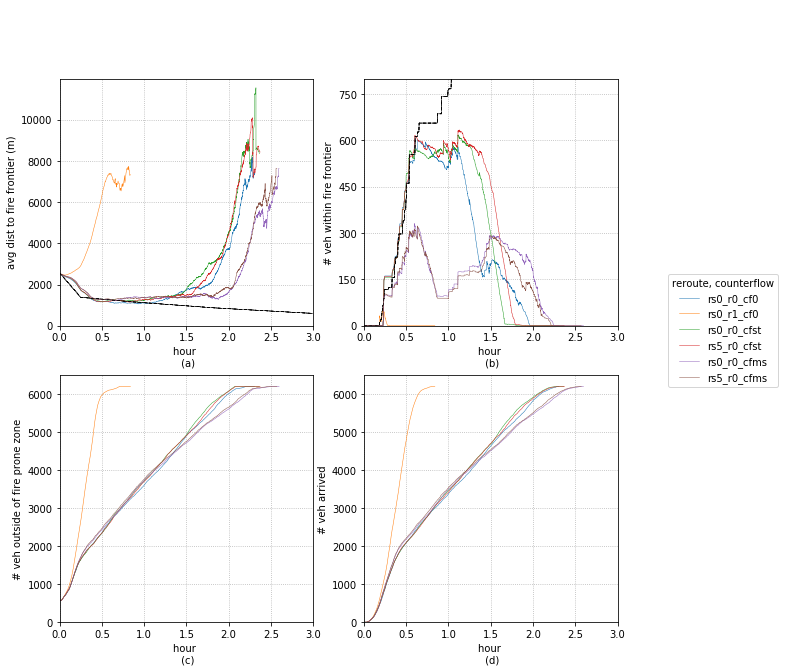

In [5]:
### Visualize four metrics under counterflow
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(' ')

ref = pd.read_csv('projects/berkeley/demand_inputs/fdist_ref.csv')

for (random_seed, reroute, counterflow) in [(0, 0, 0), (0, 1, 0), (0, 0, 'st'), (5, 0, 'st'), (0, 0, 'ms'), (5, 0, 'ms')]:
    res = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs{}_r{}_f1_dtimm_ps1000-0_tow0_cf{}.csv'.format(random_seed, reroute, counterflow))
    ax[0,0].plot(res['t']/3600, res['avg_fdist'], label="rs{}_r{}_cf{}".format(random_seed, reroute, counterflow), lw=0.5)
    ax[0,0].plot(ref['t']/3600, ref['avg_fdist'], label='no evac', ls='-.', c='black', lw=0.5)
    ax[0,0].set_ylabel('avg dist to fire frontier (m)')
    ax[0,0].set_xlabel('hour \n (a)')
    ax[0,0].set_xlim([0, 2.5])
    ax[0,0].set_ylim([0, 12000])
    ax[0,0].set_xticks(np.arange(0, 3.5, 0.5))
    ax[0,0].set_yticks(np.arange(0, 12000, 2000))
    ax[0,0].grid(ls=':')
    
    ax[0,1].plot(res['t']/3600, res['neg_fdist'], label="rs{}_r{}_cf{}".format(random_seed, reroute, counterflow), lw=0.5)
    ax[0,1].plot(ref['t']/3600, ref['neg_fdist'], label='no evac', ls='-.', c='black', lw=0.5)
    ax[0,1].set_ylabel('# veh within fire frontier')
    ax[0,1].set_xlabel('hour \n (b)')
    ax[0,1].set_xlim([0, 2.5])
    ax[0,1].set_ylim([0, 800])
    ax[0,1].set_xticks(np.arange(0, 3.5, 0.5))
    ax[0,1].set_yticks(np.arange(0, 800, 150))
    ax[0,1].grid(ls=':')
    
    ax[1,0].plot(res['t']/3600, res['out_cnts']+res['arr'], label="rs{}_r{}_cf{}".format(random_seed, reroute, counterflow), lw=0.5)
    ax[1,0].set_ylabel('# veh outside of fire prone zone')
    ax[1,0].set_xlabel('hour \n (c)')
    ax[1,0].set_xlim([0, 2.5])
    ax[1,0].set_ylim([0, 6500])
    ax[1,0].set_xticks(np.arange(0, 3.5, 0.5))
    ax[1,0].set_yticks(np.arange(0, 6500, 1000))
    ax[1,0].grid(ls=':')
    
    ax[1,1].plot(res['t']/3600, res['arr'], label="rs{}_r{}_cf{}".format(random_seed, reroute, counterflow), lw=0.5)
    ax[1,1].set_ylabel('# veh arrived')
    ax[1,1].set_xlabel('hour \n (d)')
    ax[1,1].set_xlim([0, 2.5])
    ax[1,1].set_ylim([0, 6500])
    ax[1,1].set_xticks(np.arange(0, 3.5, 0.5))
    ax[1,1].set_yticks(np.arange(0, 6500, 1000))
    ax[1,1].grid(ls=':')

plt.legend(loc=[1.2,0.95], title='reroute, counterflow')
plt.show()

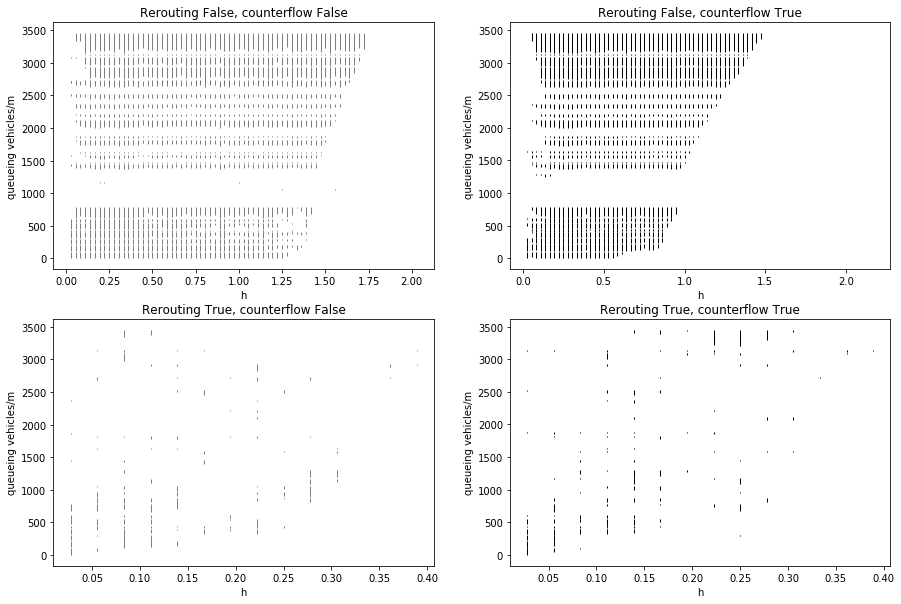

In [9]:
### Counterflow
### Queue length change with time
### No tow yet
link_df = pd.read_csv('projects/berkeley/network_inputs/osm_edges.csv')
marin_df = pd.read_csv('projects/berkeley/network_inputs/marin.csv')
spruce_df = pd.read_csv('projects/berkeley/network_inputs/spruce.csv')
cflinks_df = pd.concat([marin_df, spruce_df])
cflinks_df = pd.merge(cflinks_df.loc[cflinks_df['along']==1], link_df[['edge_id_igraph', 'length', 'lanes']], how='left', on='edge_id_igraph')
cflinks_df['cum_len'] = cflinks_df['length'].cumsum()

fig, ax = plt.subplots(2,2, figsize=(15, 10))
row_id = -1
for rerouting in [0, 1]:
    row_id += 1
    ### no counterflow
    for t in range(100, 9000, 100):
        try:
            link_stats_t = pd.read_csv('projects/berkeley/simulation_outputs/link_stats/link_stats_rs0_r{}_f1_dtimm_ps1000-0_tow0_cf0_t{}.csv'.format(rerouting, t))
        except FileNotFoundError:
            break
        cflinks_stats_t = pd.merge(cflinks_df, link_stats_t, how='left', left_on='edge_id_igraph', right_on='link_id')
        ax[row_id, 0].vlines(np.full(cflinks_stats_t.shape[0], t)/3600, cflinks_stats_t['cum_len']-cflinks_stats_t['q']*8/cflinks_stats_t['lanes'], cflinks_stats_t['cum_len'], color='black', linewidth=0.5)
        ax[row_id, 0].set_xlabel('h')
        ax[row_id, 0].set_ylabel('queueing vehicles/m')
        ax[row_id, 0].set_title('Rerouting {}, counterflow False'.format(bool(rerouting)))

    ### counterflow
    for t in range(100, 9000, 100):
        try:
            link_stats_t = pd.read_csv('projects/berkeley/simulation_outputs/link_stats/link_stats_rs0_r{}_f1_dtimm_ps1000-0_tow0_cf1_t{}.csv'.format(rerouting, t))
        except FileNotFoundError:
            break
        cflinks_stats_t = pd.merge(cflinks_df, link_stats_t, how='left', left_on='edge_id_igraph', right_on='link_id')
        ax[row_id, 1].vlines(np.full(cflinks_stats_t.shape[0], t)/3600, cflinks_stats_t['cum_len']-cflinks_stats_t['q']*8/(cflinks_stats_t['lanes']*2), cflinks_stats_t['cum_len'], color='black', linewidth=1)
        ax[row_id, 1].set_xlabel('h')
        ax[row_id, 1].set_ylabel('queueing vehicles/m')
        ax[row_id, 1].set_title('Rerouting {}, counterflow True'.format(bool(rerouting)))
    
plt.show()

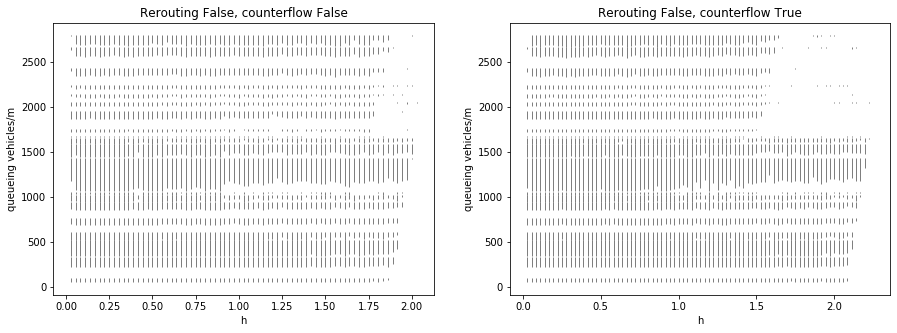

In [21]:
### check shasta to hearst, which seams to be blocked by counterflow on marin and spruce
### Counterflow
### Queue length change with time
### No tow yet
link_df = pd.read_csv('projects/berkeley/network_inputs/osm_edges.csv')
# marin_df = pd.read_csv('projects/berkeley/network_inputs/marin.csv')
# spruce_df = pd.read_csv('projects/berkeley/network_inputs/spruce.csv')
# cflinks_df = pd.concat([marin_df, spruce_df])
cflinks_df = pd.read_csv('projects/berkeley/network_inputs/shasta.csv')
cflinks_df = pd.merge(cflinks_df.loc[cflinks_df['along']==1], link_df[['edge_id_igraph', 'length', 'lanes']], how='left', on='edge_id_igraph')
cflinks_df['cum_len'] = cflinks_df['length'].cumsum()

fig, ax = plt.subplots(1,2, figsize=(15, 5))
for rerouting in [0]:
    ### no counterflow
    for t in range(100, 9000, 100):
        try:
            link_stats_t = pd.read_csv('projects/berkeley/simulation_outputs/link_stats/link_stats_rs0_r{}_f1_dtimm_ps1000-0_tow0_cf0_t{}.csv'.format(rerouting, t))
        except FileNotFoundError:
            break
        cflinks_stats_t = pd.merge(cflinks_df, link_stats_t, how='left', left_on='edge_id_igraph', right_on='link_id')
        ax[0].vlines(np.full(cflinks_stats_t.shape[0], t)/3600, cflinks_stats_t['cum_len']-cflinks_stats_t['q']*8/cflinks_stats_t['lanes'], cflinks_stats_t['cum_len'], color='black', linewidth=0.5)
        ax[0].set_xlabel('h')
        ax[0].set_ylabel('queueing vehicles/m')
        ax[0].set_title('Rerouting {}, counterflow False'.format(bool(rerouting)))

    ### counterflow
    for t in range(100, 9000, 100):
        try:
            link_stats_t = pd.read_csv('projects/berkeley/simulation_outputs/link_stats/link_stats_rs0_r{}_f1_dtimm_ps1000-0_tow0_cf1_t{}.csv'.format(rerouting, t))
        except FileNotFoundError:
            break
        cflinks_stats_t = pd.merge(cflinks_df, link_stats_t, how='left', left_on='edge_id_igraph', right_on='link_id')
        ax[1].vlines(np.full(cflinks_stats_t.shape[0], t)/3600, cflinks_stats_t['cum_len']-cflinks_stats_t['q']*8/(cflinks_stats_t['lanes']), cflinks_stats_t['cum_len'], color='black', linewidth=0.5)
        ax[1].set_xlabel('h')
        ax[1].set_ylabel('queueing vehicles/m')
#         ax[1].set_ylim([1500, 2000])
        ax[1].set_title('Rerouting {}, counterflow True'.format(bool(rerouting)))
    
plt.show()
# print(cflinks_df[cflinks_df['cum_len']<1800].tail())

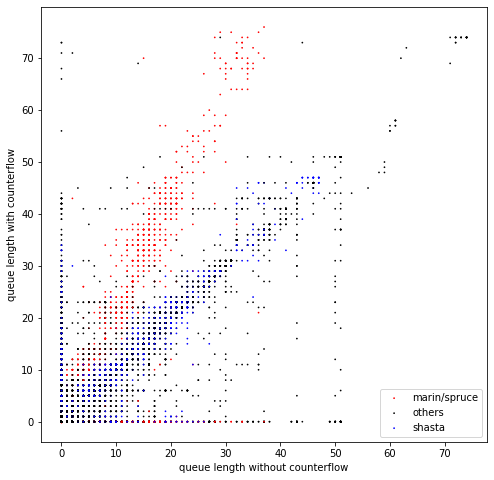

{17480: 37, 25353: 36, 3946: 50, 14131: 58, 14133: 63, 14192: 26, 11221: 26}
{3094: 766.0, 3934: 722.0, 17480: 913.0, 30427: 846.0}


In [9]:
marin_df = pd.read_csv('projects/berkeley/network_inputs/marin.csv')
spruce_df = pd.read_csv('projects/berkeley/network_inputs/spruce.csv')
shasta_df = pd.read_csv('projects/berkeley/network_inputs/shasta.csv')
big_roads = marin_df['edge_id_igraph'].values.tolist()+spruce_df['edge_id_igraph'].values.tolist()+shasta_df['edge_id_igraph'].values.tolist()

fig, ax = plt.subplots(figsize=(8, 8))
big_deviation_links = {}
big_dev_values_links = {}
for t in range(100, 9000, 100):
    try:
        link_stats_t_cf0 = pd.read_csv('projects/berkeley/simulation_outputs/link_stats/link_stats_rs0_r0_f1_dtimm_ps1000-0_tow0_cf0_t{}.csv'.format(t))
        link_stats_t_cfms = pd.read_csv('projects/berkeley/simulation_outputs/link_stats/link_stats_rs0_r0_f1_dtimm_ps1000-0_tow0_cfms_t{}.csv'.format(t))
    except FileNotFoundError:
        break
    link_stats_compare_df = pd.merge(link_stats_t_cf0[['link_id', 'q']], link_stats_t_cfms[['link_id', 'q']], how='outer', on='link_id', suffixes=['_0', '_ms'])
    link_stats_compare_df = link_stats_compare_df.fillna({'q_0': 0, 'q_ms': 0})
    link_stats_compare_df['c'] = 'black'
    link_stats_compare_df['c'] = np.where(link_stats_compare_df['link_id'].isin(marin_df['edge_id_igraph']), 'r', link_stats_compare_df['c'])
    link_stats_compare_df['c'] = np.where(link_stats_compare_df['link_id'].isin(spruce_df['edge_id_igraph']), 'r', link_stats_compare_df['c'])
    link_stats_compare_df['c'] = np.where(link_stats_compare_df['link_id'].isin(shasta_df['edge_id_igraph']), 'blue', link_stats_compare_df['c'])
    link_stats_compare_df['legend'] = np.where(link_stats_compare_df['c']=='r', 'marin/spruce',
                                              np.where(link_stats_compare_df['c']=='blue', 'shasta', 'others'))
    for nm, grp in link_stats_compare_df.groupby('legend'):
        if t==100: ax.scatter(grp['q_0'], grp['q_ms'], c=grp['c'], s=0.5, label=nm)
        else: ax.scatter(grp['q_0'], grp['q_ms'], c=grp['c'], s=0.5)
    
    big_deviation_links_t = link_stats_compare_df.loc[link_stats_compare_df['q_ms']-link_stats_compare_df['q_0']>2*link_stats_compare_df['q_0'], 'link_id'].values.tolist()
    for l in big_deviation_links_t:
        if l not in big_roads:
            try:
                big_deviation_links[l] += 1
            except KeyError:
                big_deviation_links[l] = 1
    for l in link_stats_compare_df.itertuples():
        if getattr(l, 'link_id') not in big_roads:
            try:
                big_dev_values_links[getattr(l, 'link_id')] += getattr(l, 'q_ms') - getattr(l, 'q_0')
            except KeyError:
                big_dev_values_links[getattr(l, 'link_id')] = getattr(l, 'q_ms') - getattr(l, 'q_0')
    
#     print(link_stats_compare_df[link_stats_compare_df['link_id']==25353])
plt.xlabel('queue length without counterflow')
plt.ylabel('queue length with counterflow')
plt.legend()
plt.show()
print({k: v for k, v in big_deviation_links.items() if v>25})
print({k: v for k, v in big_dev_values_links.items() if v>700})

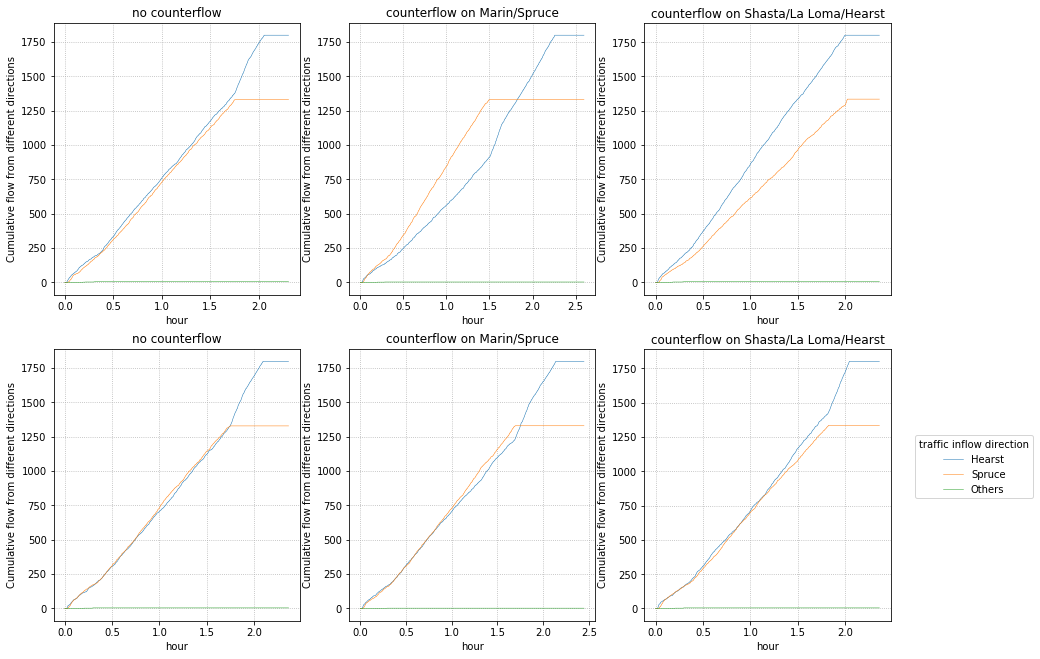

In [17]:
### node passage at Spruce Hearst intersection
fig, ax = plt.subplots(2,3, figsize=(15,11))
ax_id = -1
counterflow_dict = {0: 'no counterflow', 'ms': 'counterflow on Marin/Spruce', 'st': 'counterflow on Shasta/La Loma/Hearst'}
for counterflow in [0, 'ms', 'st']:
    ax_id += 1
    res = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs0_r0_f1_dtimm_ps1000-0_tow0_cf{}.csv'.format(counterflow))
    ax[0, ax_id].plot(res['t']/3600, res['hearst_flow'].cumsum(), label="Hearst", lw=0.5)
    ax[0, ax_id].plot(res['t']/3600, res['spruce_flow'].cumsum(), label="Spruce", lw=0.5)
    ax[0, ax_id].plot(res['t']/3600, res['other_flow'].cumsum(), label="Others", lw=0.5)
    ax[0, ax_id].set_title('{}'.format(counterflow_dict[counterflow]))
    ax[0, ax_id].set_ylabel('Cumulative flow from different directions')
    ax[0, ax_id].set_xlabel('hour')
    ax[0, ax_id].grid(ls=':')
    
    res_anode = pd.read_csv('projects/berkeley/simulation_outputs/t_stats/t_stats_rs0_r0_f1_dtimm_ps1000-0_tow0_cf{}_anode.csv'.format(counterflow))
    ax[1, ax_id].plot(res_anode['t']/3600, res_anode['hearst_flow'].cumsum(), label="Hearst", lw=0.5)
    ax[1, ax_id].plot(res_anode['t']/3600, res_anode['spruce_flow'].cumsum(), label="Spruce", lw=0.5)
    ax[1, ax_id].plot(res_anode['t']/3600, res_anode['other_flow'].cumsum(), label="Others", lw=0.5)
    ax[1, ax_id].set_title('{}'.format(counterflow_dict[counterflow]))
    ax[1, ax_id].set_ylabel('Cumulative flow from different directions')
    ax[1, ax_id].set_xlabel('hour')
    ax[1, ax_id].grid(ls=':')
plt.legend(loc=[1.1,0.45], title='traffic inflow direction')
plt.show()

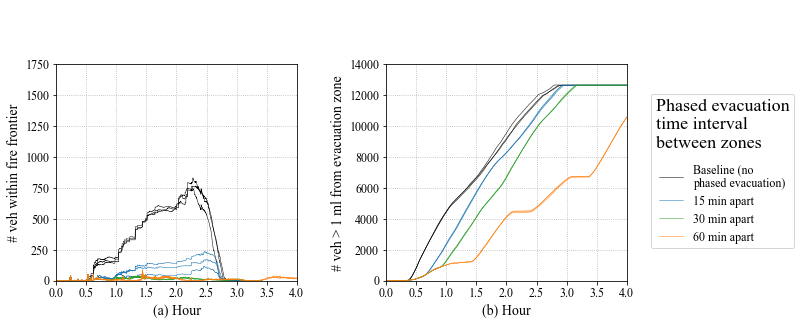

In [125]:
matplotlib.rc('text', usetex = False)
### baseline parameters
b_random_seed=0
b_fire_speed, d_fire_speed = 1, {1: 'Baseline: 1991\nOakland Hills Fire', 0.5: r'0.5 $\times$ baseline speed', 2: r'2.0 $\times$ baseline speed'}
b_dept_time_id, d_dept_time_id, d_dept_time_id2 = 'mid', {
    'fst': 'Fast:\nN(20 min, 10 min)', 
    'mid': 'Baseline (medium):\nN(40 min, 20 min)', 
    'slw': 'Slow:\nN(60 min, 30 min)'}, {
    'fst': 'Medium scenario\ncumulative departure', 
    'mid': 'Baseline\ncumulative departure', 
    'slw': 'Slow scenario\ncumulative departure'}
b_tow_pct, d_tow_pct = 0.1, {0: '0%', 0.1: 'Baseline (10%)', 0.25: '25%'}
b_hh_veh, d_hh_veh = 'survey', {'survey': 'Baseline (survey):\n44%/43%/13% hh\nwith 1/2/3 veh', 1: '1 veh/hh', 3: '3 veh/hh'}
b_reroute_pct, d_reroute_pct = 0.15, {0: '0%', 0.15: 'Baseline (15%)', 0.5: '50%', 1: '100%'}
b_phase_tdiff, d_phase_tdiff = 0, {0: 'Baseline (no\nphased evacuation)', 15: '15 min apart', 30: '30 min apart', 60: '60 min apart'}
b_counterflow, d_counterflow = 0, {0: 'Baseline\n(no contraflow)', 1: 'Contraflow'}

### fire speed
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5)
fig.suptitle(' ')
color = iter(['k', plt.rcParams['axes.prop_cycle'].by_key()['color'][0], plt.rcParams['axes.prop_cycle'].by_key()['color'][2], plt.rcParams['axes.prop_cycle'].by_key()['color'][1]])

# for fire_speed in [1, 0.5, 2]:
# for dept_time_id in ['fst', 'mid', 'slw']:
# for tow_pct in [0, 0.1, 0.25]:
# for hh_veh in ['survey', 1, 3]:
# for reroute_pct in [0, 0.15, 0.5, 1]:
for phase_tdiff in [0, 15, 30, 60]:
# for counterflow in [0, 1]:
    c = next(color)
    for random_seed in [0, 5, 10]:
        try:
            file_name = 'projects/berkeley/simulation_outputs/t_stats_surveybase/t_stats_rs{}_f{}_dt{}_tow{}_hhv{}_r{}_pt{}_cf{}.csv'.format(
                random_seed, b_fire_speed, b_dept_time_id, b_tow_pct, b_hh_veh, b_reroute_pct, phase_tdiff, b_counterflow)
            res = pd.read_csv(file_name)
        except FileNotFoundError:
            print('{} not found'.format(file_name))
            continue
        line,= ax[0].plot(res['t']/3600, res['neg_fdist'], lw=0.5, c=c)
        if random_seed == 0:
            line.set_label(d_phase_tdiff[phase_tdiff])
        ax[0].set_ylabel('# veh within fire frontier')
        ax[0].set_xlabel('(a) Hour')
        ax[0].set_xlim([0, 4])
        ax[0].set_ylim([0, 1750])
#         ax[0].set_ylim([0, 3000])
        ax[0].set_xticks(np.arange(0, 4.5, 0.5))
        ax[0].set_yticks(np.arange(0, 1800, 250))
        ax[0].grid(ls=':')

        ax[1].plot((res['t']/3600).values.tolist()+[6], (res['out_evac_buffer_cnts']+res['arr']).values.tolist()+[np.max(res['arr'])], lw=0.5, c=c)
#         line2,= ax[1].plot((res['t']/3600).values.tolist(), (12677-res['init']-res['load']).values.tolist(), lw=0.5, c=c, ls='--', dashes=(5, 10))
#         if (random_seed == 0) and (dept_time_id==b_dept_time_id):
#             ax[1].text(0.35, 11000, 'Dashed line:\ncumulative\ndeparture')
#             ax[1].text(2, 5000, 'Solid line:\nvehicles >1 mile from\nthe evacuation area')
#         ax[1].set_ylabel('# veh > 1 ml from evacuation zone\nor # veh started evacuation')
        ax[1].set_ylabel('# veh > 1 ml from evacuation zone')
        ax[1].set_xlabel('(b) Hour')
        ax[1].set_xlim([0, 4])
        ax[1].set_ylim([0, 14000])
#         ax[1].set_ylim([0, 20000])
        ax[1].set_xticks(np.arange(0, 4.5, 0.5))
        ax[1].set_yticks(np.arange(0, 15000, 2000))
        ax[1].grid(ls=':')

handles, labels = ax[0].get_legend_handles_labels()
handles2, labels2 = ax[1].get_legend_handles_labels()
leg = plt.legend(handles+handles2, labels+labels2, loc=[1.1,0.15])
leg.set_title("Phased evacuation\ntime interval\nbetween zones", prop = {'size': 18})
leg._legend_box.sep = 12
leg._legend_box.align = "center"
plt.show()

In [126]:
random_seed_l = [0, 5, 10, 1, 8]
fire_speed_l = [1, 0.5, 2]
dept_time_id_l = ['mid', 'fst', 'slw']
tow_pct_l = [0.1, 0, 0.25]
hh_veh_l = ['survey', 1, 3]
reroute_pct_l = [0.15, 0, 0.5, 1]
phase_tdiff_l = [0, 15, 30, 60]
counterflow_l = [0, 1]
scen_l = [random_seed_l, fire_speed_l, dept_time_id_l, tow_pct_l, hh_veh_l, reroute_pct_l, phase_tdiff_l, counterflow_l]

metric_l = []
for (rs, f, dt, tow, hhv, r, pt, cf) in list(itertools.product(*scen_l)):
    scen_nm = 't_stats_rs{}_f{}_dt{}_tow{}_hhv{}_r{}_pt{}_cf{}.csv'.format(rs, f, dt, tow, hhv, r, pt, cf)
    try:
        res = pd.read_csv('projects/berkeley/simulation_outputs/t_stats_surveybase/' + scen_nm)
    except FileNotFoundError:
#         print(scen_nm)
        continue

    ### metrics
    res = res[res['t']<=3600*4].copy()
    min_dist_to_fire = np.min(res['avg_fdist'])/1609
    max_in_fire_frontier = np.max(res['neg_fdist'])
    tot_in_fire_frontier = np.sum(res['neg_fdist'])/3600
    tot_veh_cnts = pd.read_csv('projects/berkeley/demand_inputs/od_rs{}_hhv{}.csv'.format(rs, hhv)).shape[0]
#     print(tot_veh_cnts, 't_stats_rs{}_f{}_dt{}_tow{}_hhv{}_r{}_pt{}_cf{}.csv'.format(rs, f, dt, tow, hhv, r, pt, cf))
    safe_time = np.min(res.loc[(res['out_evac_buffer_cnts']+res['arr']==tot_veh_cnts), 't'])/3600
    arr_time = np.min(res.loc[res['arr']==tot_veh_cnts, 't'])/3600
    max_sim_t = np.max(res['t'])/3600
    metric_l.append([rs, f, dt, tow, hhv, r, pt, cf, min_dist_to_fire, max_in_fire_frontier, tot_in_fire_frontier, safe_time, arr_time, max_sim_t])

metric_df = pd.DataFrame(metric_l, columns=['rs', 'f', 'dt', 'tow', 'hhv', 'r', 'pt', 'cf', 'min_dist_to_fire', 'max_in_fire_frontier', 'tot_in_fire_frontier', 'safe_time', 'arr_time', 'max_sim_t'])
print(metric_df.shape)
summary_df = metric_df.groupby(['f', 'dt', 'tow', 'hhv', 'r', 'pt', 'cf']).agg({'max_in_fire_frontier': np.mean, 'safe_time': np.mean, 'tot_in_fire_frontier': np.mean, 'min_dist_to_fire': [np.mean, 'count']}).round(2)
display(summary_df)
summary_df['max_in_fire_frontier']=np.round((summary_df['max_in_fire_frontier']/781.67-1)*100)
summary_df['safe_time']=np.round((summary_df['safe_time']/2.87-1)*100)
display(summary_df)

(48, 14)


max_in_fire_frontier safe_time  \
                                               mean      mean   
f   dt  tow  hhv    r    pt cf                                  
0.5 mid 0.10 survey 0.15 0  0                341.67      2.83   
1.0 fst 0.10 survey 0.15 0  0                729.33      2.73   
    mid 0.00 survey 0.15 0  0                756.67      2.75   
        0.10 1      0.15 0  0                245.00      1.85   
             3      0.15 0  0               2496.67       NaN   
             survey 0.00 0  0                934.33      3.18   
                    0.15 0  0                781.67      2.87   
                            1                411.00      2.67   
                         15 0                172.67      2.93   
                         30 0                 49.33      3.16   
                         60 0                 80.33       NaN   
                    0.50 0  0                380.67      2.07   
                    1.00 0  0                 85.67      1.21   
        0.25 survey 0.15 0  0                820.67      2.94   
    slw 0.10 survey 0.15 0  0                747.00      3.08   
2.0 mid 0.10 survey 0.15 0  0               1209.33      2.80   

                               tot_in_fire_frontier min_dist_to_fire        
                                               mean             mean count  
f   dt  tow  hhv    r    pt cf                                              
0.5 mid 0.10 survey 0.15 0  0                350.12             0.76     3  
1.0 fst 0.10 survey 0.15 0  0                910.42             0.40     3  
    mid 0.00 survey 0.15 0  0                884.57             0.66     3  
        0.10 1      0.15 0  0                128.82             0.88     3  
             3      0.15 0  0               5057.40             0.36     3  
             survey 0.00 0  0               1320.23             0.57     3  
                    0.15 0  0                954.06             0.64     3  
                            1                410.24             0.72     3  
                         15 0                188.15             0.75     3  
                         30 0                 34.69             0.82     3  
                         60 0                 40.32             0.69     3  
                    0.50 0  0                278.58             0.78     3  
                    1.00 0  0                 34.62             0.69     3  
        0.25 survey 0.15 0  0               1019.05             0.64     3  
    slw 0.10 survey 0.15 0  0                906.31             0.62     3  
2.0 mid 0.10 survey 0.15 0  0               1569.38             0.45     3

max_in_fire_frontier safe_time  \
                                               mean      mean   
f   dt  tow  hhv    r    pt cf                                  
0.5 mid 0.10 survey 0.15 0  0                 -56.0      -1.0   
1.0 fst 0.10 survey 0.15 0  0                  -7.0      -5.0   
    mid 0.00 survey 0.15 0  0                  -3.0      -4.0   
        0.10 1      0.15 0  0                 -69.0     -36.0   
             3      0.15 0  0                 219.0       NaN   
             survey 0.00 0  0                  20.0      11.0   
                    0.15 0  0                   0.0       0.0   
                            1                 -47.0      -7.0   
                         15 0                 -78.0       2.0   
                         30 0                 -94.0      10.0   
                         60 0                 -90.0       NaN   
                    0.50 0  0                 -51.0     -28.0   
                    1.00 0  0                 -89.0     -58.0   
        0.25 survey 0.15 0  0                   5.0       2.0   
    slw 0.10 survey 0.15 0  0                  -4.0       7.0   
2.0 mid 0.10 survey 0.15 0  0                  55.0      -2.0   

                               tot_in_fire_frontier min_dist_to_fire        
                                               mean             mean count  
f   dt  tow  hhv    r    pt cf                                              
0.5 mid 0.10 survey 0.15 0  0                350.12             0.76     3  
1.0 fst 0.10 survey 0.15 0  0                910.42             0.40     3  
    mid 0.00 survey 0.15 0  0                884.57             0.66     3  
        0.10 1      0.15 0  0                128.82             0.88     3  
             3      0.15 0  0               5057.40             0.36     3  
             survey 0.00 0  0               1320.23             0.57     3  
                    0.15 0  0                954.06             0.64     3  
                            1                410.24             0.72     3  
                         15 0                188.15             0.75     3  
                         30 0                 34.69             0.82     3  
                         60 0                 40.32             0.69     3  
                    0.50 0  0                278.58             0.78     3  
                    1.00 0  0                 34.62             0.69     3  
        0.25 survey 0.15 0  0               1019.05             0.64     3  
    slw 0.10 survey 0.15 0  0                906.31             0.62     3  
2.0 mid 0.10 survey 0.15 0  0               1569.38             0.45     3

In [120]:
tot_veh_l = []
tot_veh_d = {}
for rs in [0, 1, 8, 5, 10]:
    for hhv in ['survey', 1, 3]:
        try:
            tot_veh_cnts = pd.read_csv('projects/berkeley/demand_inputs/od_rs{}_hhv{}.csv'.format(rs, hhv)).shape[0]
        except FileNotFoundError:
            continue
        tot_veh_l.append([rs, hhv, tot_veh_cnts])
        try:
            tot_veh_d[rs][hhv] = tot_veh_cnts
        except KeyError:
            tot_veh_d[rs] = {hhv: tot_veh_cnts}
tot_veh_df = pd.DataFrame(tot_veh_l, columns=['rs', 'hhv', 'tot_veh'])
print(tot_veh_df.groupby('hhv').agg({'tot_veh': np.mean}))
# print(tot_veh_d)

### Fire
# for rs in [0, 5, 10]:
#     base_scen_nm = 't_stats_rs{}_f1_dtmid_tow0.1_hhvsurvey_r0.15_pt0_cf0.csv'.format(rs)
#     res_base = pd.read_csv('projects/berkeley/simulation_outputs/t_stats_surveybase/' + base_scen_nm)
#     print(round(np.min(res_base.loc[res_base['neg_fdist']>0, 't'])/60, 1))
#     print(res_base.nlargest(1, 'neg_fdist'))

### Dept time
# for rs in [0, 1, 8]:
#     base_scen_nm = 't_stats_rs{}_f1_dtfst_tow0.1_hhvsurvey_r0.15_pt0_cf0.csv'.format(rs)
#     res_base = pd.read_csv('projects/berkeley/simulation_outputs/t_stats_surveybase/' + base_scen_nm)
#     print(np.min(res_base.loc[((res_base['out_evac_buffer_cnts']+res_base['arr'])
#                                >=0.99*tot_veh_d[rs]['survey']), 't'])/60)

# for rs in [0, 5, 10]:
#     alt_scen_nm = 't_stats_rs{}_f1_dtmid_tow0.1_hhvsurvey_r0.15_pt0_cf0.csv'.format(rs)
#     res_alt = pd.read_csv('projects/berkeley/simulation_outputs/t_stats_surveybase/' + alt_scen_nm)
#     print(np.min(res_alt.loc[((res_alt['out_evac_buffer_cnts']+res_alt['arr'])
#                                >=0.99*tot_veh_d[rs]['survey']), 't'])/60)
    
#     alt_scen_nm = 't_stats_rs{}_f1_dtslw_tow0.1_hhvsurvey_r0.15_pt0_cf0.csv'.format(rs)
#     res_alt = pd.read_csv('projects/berkeley/simulation_outputs/t_stats_surveybase/' + alt_scen_nm)
#     print(np.min(res_alt.loc[((res_alt['out_evac_buffer_cnts']+res_alt['arr'])
#                                >=0.99*tot_veh_d[rs]['survey']), 't'])/60)
    
### Mode split
for rs in [0, 5, 10]:
    alt_scen_nm = 't_stats_rs{}_f1_dtmid_tow0.1_hhv3_r0.15_pt0_cf0.csv'.format(rs)
    res_alt = pd.read_csv('projects/berkeley/simulation_outputs/t_stats_surveybase/' + alt_scen_nm)
    print(res_alt.tail(1))

             tot_veh
hhv                 
1        7438.333333
3       22358.000000
survey  12591.800000
           t  init   load      arr  move  avg_fdist  neg_fdist  \
14400  14400   0.0  674.0  19860.0    84     593.59       1702   

       out_evac_zone_cnts  out_evac_buffer_cnts  
14400                 539                   335  
           t  init   load      arr  move  avg_fdist  neg_fdist  \
14400  14400   0.0  708.0  19990.0    84     635.52       1663   

       out_evac_zone_cnts  out_evac_buffer_cnts  
14400                 469                   301  
           t  init   load      arr  move  avg_fdist  neg_fdist  \
14400  14400   0.0  656.0  20009.0    95     625.85       1636   

       out_evac_zone_cnts  out_evac_buffer_cnts  
14400                 543                   310  
